In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess

## Tests for the C++ implementation of Glikonal-G
we compare the solution of Glikonal-G to the true solution in a number of settings where the latter is computable

In [2]:
# compile the c++ code
compile_line="g++ glikonal_grrp.cpp -o glikonal_grrp_out -std=c++17 -O3"
split_line=compile_line.split(" ")
result = subprocess.run(split_line, capture_output=True, text=True)
print(result.stdout)  

In [3]:
def point_source_HJB_uniform_solver(init_pos,init_altitude,radius,H,W,hy,hx,velocity_func):
    """
    Solves exactly the HJB equation for GRRP with a point source at pos_seed and a uniform velocity field. Uniform means that the velocity velocity_func(pos,a) is constant in pos, but not necessarily in a.
    The solution is computed on a grid of size HxW nodes, with x and y spacing respectively hx and hy.
    In this case the solution is easy because the characteristics are just straight lines, so the solution at x is just the distance between x and the source, divided by the velocity in direction x-source.
    
    Args:
    pos_seed: tuple of two integers, representing the position of the source.
    radius: float, the radius  around pos_seed where the solution is computed.
    H: integer, number of rows in the grid.
    W: integer, number of columns in the grid.
    hx: float, the x-spacing of the grid.
    hy: float, the y-spacing of the grid.
    velocity_func: function, representing the velocity field of the graph as a function of the position and the direction. It is assumed that the velocity does not depend on the position. Takes as input a tuple of two integers (the position x) and a numpy array of two floats (the direction a), and returns a positive float.
   
    Returns:
    node_list: list of tuples of two integers, representing the nodes in the grid at distance at most radius from pos_seed.
    values: list of floats, representing the value of the arrival time at each node in node_list.
    """
    node_list=[init_pos]
    arrival_times=[init_altitude]
    char_list=[np.array([0,0])]

    nx=int(np.ceil(radius/hx)) #number of nodes in the x direction at distance at most radius from pos_seed
    ny=int(np.ceil(radius/hy))
    for y in range(init_pos[0]-ny,init_pos[0]+ny+1):
        for x in range(init_pos[1]-nx,init_pos[1]+nx+1):
            if((y-init_pos[0])**2+(x-init_pos[1])**2<=radius**2 and is_in_grid((y,x),H,W) and (y,x)!=init_pos):
                displacement=np.array((hy*(y-init_pos[0]),hx*(x-init_pos[1])))
                displacement_norm=np.linalg.norm(displacement)
                node_list.append((y,x))
                char_list.append(displacement/displacement_norm) 
                arrival_times.append(init_altitude-displacement_norm/velocity_func(displacement/displacement_norm))
    return node_list,arrival_times,char_list 

def is_in_grid(pos,H,W):
    """
    Function that checks if a given position is inside the grid with dimensions HxW.
    Args:
    pos: tuple of two integers, representing the position in the grid.
    H: integer, number of rows in the grid.
    W: integer, number of columns in the grid.

    Returns:
    boolean: True if the position is inside the grid, False otherwise.
    """
    y,x=pos
    if (y<0 or y>H-1 or x<0 or x>W-1):
        return False
    else:
        return True


def glide_ratio(a,wind):
    base_glide_ratio=1. #glide ratio of the aircraft withtout wind
    k=np.linalg.norm(wind) #ratio between the wind speed and the airspeed of the aircraft. gamma should be (1+k)/(1-k)
    return base_glide_ratio*np.sqrt(1-k**2+k**2*np.sum(a*wind)**2)+k*np.sum(a*wind)

def read_grid_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    grid_matrix = []
    for line in lines:
        values = line.split()
        row = [float(value) for value in values]
        grid_matrix.append(row)

    return np.array(grid_matrix)


def read_characteristics_from_file(filename, H, W):
    char_grid_np = np.zeros((H, W, 2), dtype=np.float64)
    with open(filename, 'r') as file:
        lines = file.readlines()

    for i in range(H):
        for j in range(W):
            values = lines[i * W + j].split()
            char_grid_np[i, j, 0] = float(values[0])
            char_grid_np[i, j, 1] = float(values[1])

    return char_grid_np

## Test with uniform wind and no terrain

In [4]:
H=101  #number of horizontal points in the grid
W=101  #number of vertical points in the grid
Z=20 #number of vertical points in the wind vector field

hy=1 #grid spacing in the y direction
hx=1 #grid spacing in the x direction
h=1
hz=200 #vertical spacing of the wind vector field

#define the wind vector field
wind_angles=np.ones([H,W,Z])*2*np.pi/3 #wind angle is measured from the y axis, positive towards east (clockwise). pi/2 is east, 0 is north.
wind_field=np.zeros([H,W,Z,2])
wind_strength=0.4*np.ones([H,W,Z])
wind_field[...,0]=wind_strength*np.cos(wind_angles)
wind_field[...,1]=wind_strength*np.sin(wind_angles)

Gamma=(1+np.max(wind_strength))/(1-np.max(wind_strength)) #ratio between the largest and lowest value glide_ratio can take. In this case the glide ration in absence of wind is one.
elevation=0*np.ones([H,W]) #elevation profile

#initial position and altitude of aircraft
init_pos=(H//2,W//2) #source position
init_altitude=300

In [5]:
#initialize the slution around the initial position
radius=2.9#meters
wind=wind_field[init_pos[0],init_pos[1],int(round(init_altitude/hz))]
init_nodes,init_values,init_chars=point_source_HJB_uniform_solver(init_pos,init_altitude,radius, H,W,h,h,velocity_func=lambda a: glide_ratio(a,wind))


In [6]:
wind_filename="./data/wind.txt"
with open(wind_filename,"w") as f:
    for i in range(H):
        for j in range(W):
            for k in range(Z):
                f.write(f"{wind_field[i,j,k,0]} {wind_field[i,j,k,1]}\n")


elevation_filename="./data/elevation.txt"
with open(elevation_filename,"w") as f:
    for i in range(H):
        for j in range(W):
            f.write(f"{elevation[i,j]}\n")

# write the initial nodes and values to a file
init_filename="./data/init_values_chars.txt"
with open(init_filename,"w") as f:
    for i in range(len(init_nodes)): 
        f.write(f"{init_nodes[i][0]} {init_nodes[i][1]} {init_values[i]} {init_chars[i][0]} {init_chars[i][1]}\n")

In [7]:
output_alt_filename="./output/alt.txt"
output_char_filename="./output/char.txt"
#running the c++ code
#include the '-v' flag to print the running time of the algorithm and other information
run_line=f"./glikonal_grrp_out -h {h} -hz {hz} -H {H} -W {W} -Z {Z} -fwind {wind_filename} -felev {elevation_filename} -finit {init_filename} -out_alt {output_alt_filename} -out_char {output_char_filename}"
print(run_line)
split_line=run_line.split(" ")
result = subprocess.run(split_line, capture_output=True, text=True)
print(result.stdout)  

./glikonal_grrp_out -h 1 -hz 200 -H 101 -W 101 -Z 20 -fwind ./data/wind.txt -felev ./data/elevation.txt -finit ./data/init_values_chars.txt -out_alt ./output/alt.txt -out_char ./output/char.txt



In [8]:
#read results from file
grid = read_grid_from_file(output_alt_filename)
grid_chars = read_characteristics_from_file(output_char_filename, H, W)

/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_60599/2322260694.py:4: UserWarning: The following kwargs were not used by contour: 'label'
  CS=ax.contour(X,Y,grid,colors='white',label='aircraft',linewidths=0.7)


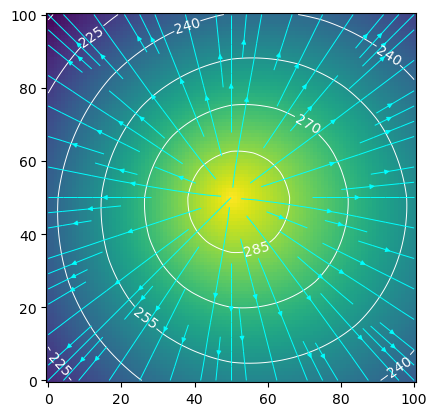

In [9]:
fig,ax=plt.subplots()
X,Y=np.meshgrid(h*np.arange(W),h*np.arange(H))
pc2=ax.pcolormesh(X,Y,grid,cmap='viridis',shading='nearest')
CS=ax.contour(X,Y,grid,colors='white',label='aircraft',linewidths=0.7)
ax.clabel(CS, inline=True, fontsize=10)
ax.streamplot(X,Y,grid_chars[:,:,1],grid_chars[:,:,0],density=0.84,color='aqua',linewidth=0.7,arrowsize=0.7)
ax.set_aspect('equal')



In [10]:
#finding the true solution
radius=np.sqrt((H*hy)**2+(hx*W)**2)
init_nodes,init_values,init_chars=point_source_HJB_uniform_solver(init_pos,init_altitude,radius, H,W,h,h,velocity_func=lambda a: glide_ratio(a,wind))
true_grid=np.inf*np.ones([H,W])
true_grid_chars=np.zeros([H,W,2])
for i,pos in enumerate(init_nodes):
    true_grid[pos]=init_values[i]
    true_grid_chars[pos]=init_chars[i]

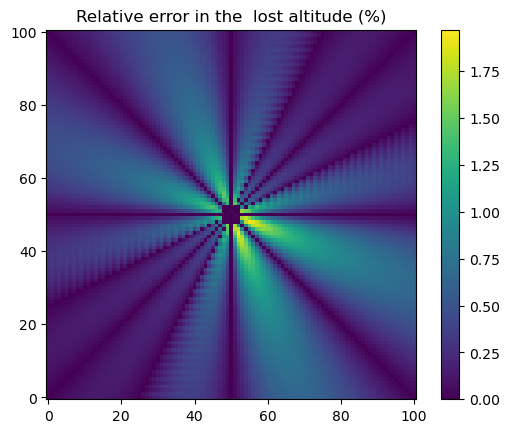

In [11]:
fig,ax=plt.subplots()
X,Y=np.meshgrid(hx*np.arange(W),hy*np.arange(H))
grid_lost_altitude=init_altitude-grid
true_grid_lost_altitude=init_altitude-true_grid
rel_error=np.abs(grid_lost_altitude-true_grid_lost_altitude)/(true_grid_lost_altitude+1e-10)

im=ax.pcolormesh(X,Y,100*rel_error,cmap='viridis',shading='nearest')
ax.set_aspect('equal')
fig.colorbar(im,ax=ax)
ax.title.set_text('Relative error in the  lost altitude (%)')

## Test with uniform wind and barrier with two slits


In [12]:
H=101 
W=101
Z=20 #number of vertical points in the wind vector field

hy=1 #grid spacing in the y direction
hx=1 #grid spacing in the x direction
h=1
hz=200 #vertical spacing of the wind vector field

#define the wind vector field
wind_angles=np.ones([H,W,Z])*0 #np.random.uniform(0,2*np.pi,size=[H,W])#with respect to the y axis, positive towards east (clockwise)
wind_field=np.zeros([H,W,Z,2])
wind_strength=0.4*np.ones([H,W,Z])
wind_field[...,0]=wind_strength*np.cos(wind_angles)
wind_field[...,1]=wind_strength*np.sin(wind_angles)
wind=wind_field[0,0,0]

Gamma=(1+np.max(wind_strength))/(1-np.max(wind_strength))#ratio between the largest and lowest value glide_ratio can take.
#this elevation profile has a barrier that extends from the top to the bottom of the grid, with two slits in at positions saddle_1 and saddle_2.
#each slit is 2 grid points wide
elevation=np.ones([H,W])
elevation[:,W//2]=100*np.ones(H)
saddle_1=80
saddle_2=20
elevation[int(hy*saddle_1)-1:int(hy*saddle_1)+1,:]=1
elevation[int(hy*saddle_2)-1:int(hy*saddle_2)+1,:]=1



#initial position and altitude of aircraft
init_pos=(H//2,0) #source position
init_altitude=120

In [13]:
radius=2.9
wind=wind_field[0,0,np.round(init_altitude/hz).astype(int)]
init_nodes,init_values,init_chars=point_source_HJB_uniform_solver(init_pos,init_altitude,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
grid=np.maximum(grid,np.zeros_like(grid))

In [14]:
wind_filename="./data/wind.txt"
with open(wind_filename,"w") as f:
    for i in range(H):
        for j in range(W):
            for k in range(Z):
                f.write(f"{wind_field[i,j,k,0]} {wind_field[i,j,k,1]}\n")


elevation_filename="./data/elevation.txt"
with open(elevation_filename,"w") as f:
    for i in range(H):
        for j in range(W):
            f.write(f"{elevation[i,j]}\n")

# write the initial nodes and values to a file
init_filename="./data/init_values_chars.txt"
with open(init_filename,"w") as f:
    for i in range(len(init_nodes)): 
        f.write(f"{init_nodes[i][0]} {init_nodes[i][1]} {init_values[i]} {init_chars[i][0]} {init_chars[i][1]}\n")


In [15]:
output_alt_filename="./output/alt.txt"
output_char_filename="./output/char.txt"
#running the c++ code
#include the '-v' flag to print the running time of the algorithm and other information
run_line=f"./glikonal_grrp_out -h {h} -hz {hz} -H {H} -W {W} -Z {Z} -fwind {wind_filename} -felev {elevation_filename} -finit {init_filename} -out_alt {output_alt_filename} -out_char {output_char_filename}"
print(run_line)
split_line=run_line.split(" ")
result = subprocess.run(split_line, capture_output=True, text=True)
print(result.stdout)  

./glikonal_grrp_out -h 1 -hz 200 -H 101 -W 101 -Z 20 -fwind ./data/wind.txt -felev ./data/elevation.txt -finit ./data/init_values_chars.txt -out_alt ./output/alt.txt -out_char ./output/char.txt



In [16]:
#computing the true solution
radius=np.sqrt((H*hy)**2+(hx*W)**2)
init_nodes,init_values,init_chars=point_source_HJB_uniform_solver(init_pos,init_altitude,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
init_pos_saddle1=(int(saddle_1*hy),int(hx*(W//2)))
alt_saddle1=init_values[init_nodes.index(init_pos_saddle1)]

init_pos_saddle11=(int(saddle_1*hy)-1,int(hx*(W//2)))
alt_saddle11=init_values[init_nodes.index(init_pos_saddle11)]

init_pos_saddle2=(int(saddle_2*hy),int(hx*(W//2)))
alt_saddle2=init_values[init_nodes.index(init_pos_saddle2)]

init_pos_saddle22=(int(saddle_2*hy)-1,int(hx*(W//2)))
alt_saddle22=init_values[init_nodes.index(init_pos_saddle22)]

init_nodes1,init_values1,init_chars1=point_source_HJB_uniform_solver(init_pos_saddle1,alt_saddle1,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
init_nodes11,init_values11,init_chars11=point_source_HJB_uniform_solver(init_pos_saddle11,alt_saddle11,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))

init_nodes2,init_values2,init_chars2=point_source_HJB_uniform_solver(init_pos_saddle2,alt_saddle2,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
init_nodes22,init_values22,init_chars22=point_source_HJB_uniform_solver(init_pos_saddle22,alt_saddle22,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))


true_grid=np.inf*np.ones([H,W])

for i,pos in enumerate(init_nodes):
    true_grid[pos]=init_values[i]
for i,pos in enumerate(init_nodes1):
    if(pos[1]>W//2):
        true_grid[pos]=max([init_values2[init_nodes2.index(pos)],init_values1[init_nodes1.index(pos)],init_values22[init_nodes22.index(pos)],init_values11[init_nodes11.index(pos)]])

true_grid=np.maximum(true_grid,np.zeros_like(true_grid))


grid = read_grid_from_file(output_alt_filename)
grid_chars = read_characteristics_from_file(output_char_filename, H, W)

/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_60599/193262302.py:9: UserWarning: The following kwargs were not used by contour: 'label'
  CS=ax.contour(X,Y,grid,colors='w',label='aircraft',linewidths=0.7)


Text(0.5, 1.0, 'total error lost altitude')

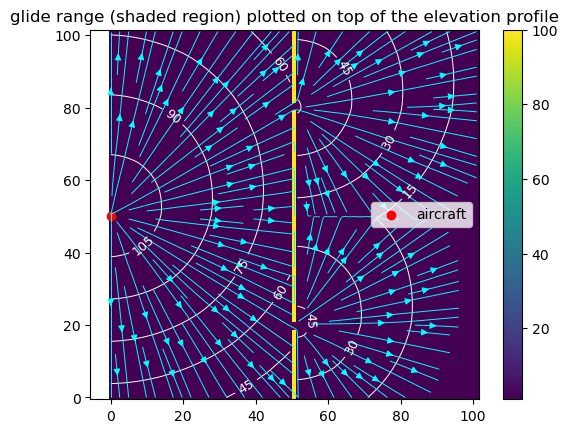

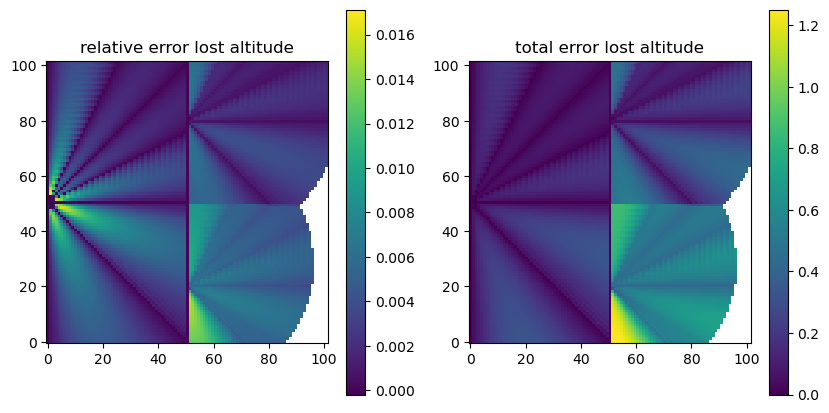

In [17]:
X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))
fig,ax=plt.subplots()

pc=ax.pcolormesh(X,Y,elevation,cmap='viridis',shading='nearest')
#pc2=ax.pcolormesh(X,Y,grid>0,cmap='binary',shading='nearest',alpha=0.1)
ax.scatter([init_pos[1]*hx],[init_pos[0]*hy],color='r',label='aircraft')
ax.legend()
fig.colorbar(pc)
CS=ax.contour(X,Y,grid,colors='w',label='aircraft',linewidths=0.7)
ax.streamplot(X,Y,grid_chars[:,:,1],grid_chars[:,:,0],density=1.4,color='aqua',linewidth=0.7)

ax.clabel(CS, fontsize=9, inline=True)
ax.set_aspect('equal')
ax.set_title('glide range (shaded region) plotted on top of the elevation profile')

grid[:,W//2]=0
true_grid[:,W//2]=0

lost_altitude=init_altitude-grid
true_lost_altitude=init_altitude-true_grid
tot_error=lost_altitude-true_lost_altitude
rel_error=tot_error/(true_lost_altitude+1e-10)
fig,axes=plt.subplots(1,2,figsize=(10,5))
im1=axesim1=axes[0].pcolormesh(X,Y,rel_error,cmap='viridis',shading='nearest')
im2=axes[1].pcolormesh(X,Y,tot_error,cmap='viridis',shading='nearest')

fig.colorbar(im1,ax=axes[0])
fig.colorbar(im2,ax=axes[1])
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

axes[0].set_title('relative error lost altitude')
axes[1].set_title('total error lost altitude')

## Example of mountain range without passes
In this case, the glider can pass the mountain range if it flies directly towards it, but arrives too low if it proceed obliquously.

In [18]:
H=101 
W=101
Z=20 #number of vertical points in the wind vector field

hy=1 #grid spacing in the y direction
hx=1 #grid spacing in the x direction
hz=200 #vertical spacing of the wind vector field

#define the wind vector field
wind_angles=np.ones([H,W,Z])*0 #np.random.uniform(0,2*np.pi,size=[H,W])#with respect to the y axis, positive towards east (clockwise)
wind_field=np.zeros([H,W,Z,2])
wind_strength=0.3*np.ones([H,W,Z])
wind_field[...,0]=wind_strength*np.cos(wind_angles)
wind_field[...,1]=wind_strength*np.sin(wind_angles)
wind=wind_field[0,0,0]

Gamma=(1+np.max(wind_strength))/(1-np.max(wind_strength))#ratio between the largest and lowest value glide_ratio can take.
#this elevation profile has a barrier that extends from the top to the bottom of the grid, with two slits in at positions saddle_1 and saddle_2.
#each slit is 2 grid points wide
elevation=np.ones([H,W])
elevation[:,W//2]=45*np.ones(H)


#initial position and altitude of aircraft
init_pos=(H//2,0) #source position
init_altitude=100

In [19]:
radius=2.9
wind=wind_field[0,0,np.round(init_altitude/hz).astype(int)]
init_nodes,init_values,init_chars=point_source_HJB_uniform_solver(init_pos,init_altitude,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
grid=np.maximum(grid,np.zeros_like(grid))

In [20]:
wind_filename="./data/wind.txt"
with open(wind_filename,"w") as f:
    for i in range(H):
        for j in range(W):
            for k in range(Z):
                f.write(f"{wind_field[i,j,k,0]} {wind_field[i,j,k,1]}\n")


elevation_filename="./data/elevation.txt"
with open(elevation_filename,"w") as f:
    for i in range(H):
        for j in range(W):
            f.write(f"{elevation[i,j]}\n")

# write the initial nodes and values to a file
init_filename="./data/init_values_chars.txt"
with open(init_filename,"w") as f:
    for i in range(len(init_nodes)): 
        f.write(f"{init_nodes[i][0]} {init_nodes[i][1]} {init_values[i]} {init_chars[i][0]} {init_chars[i][1]}\n")

In [21]:
output_alt_filename="./output/alt.txt"
output_char_filename="./output/char.txt"
#running the c++ code
#include the '-v' flag to print the running time of the algorithm and other information
run_line=f"./glikonal_grrp_out -h {h} -hz {hz} -H {H} -W {W} -Z {Z} -fwind {wind_filename} -felev {elevation_filename} -finit {init_filename} -out_alt {output_alt_filename} -out_char {output_char_filename}"
print(run_line)
split_line=run_line.split(" ")
result = subprocess.run(split_line, capture_output=True, text=True)
print(result.stdout)
grid = read_grid_from_file(output_alt_filename)
grid_chars = read_characteristics_from_file(output_char_filename, H, W)

./glikonal_grrp_out -h 1 -hz 200 -H 101 -W 101 -Z 20 -fwind ./data/wind.txt -felev ./data/elevation.txt -finit ./data/init_values_chars.txt -out_alt ./output/alt.txt -out_char ./output/char.txt



/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_60599/405863634.py:42: UserWarning: The following kwargs were not used by contour: 'label'
  CS=ax.contour(X,Y,true_grid,colors='w',label='aircraft',linewidths=0.7)


Text(0.5, 1.0, 'glide range (shaded region) plotted on top of the elevation profile')

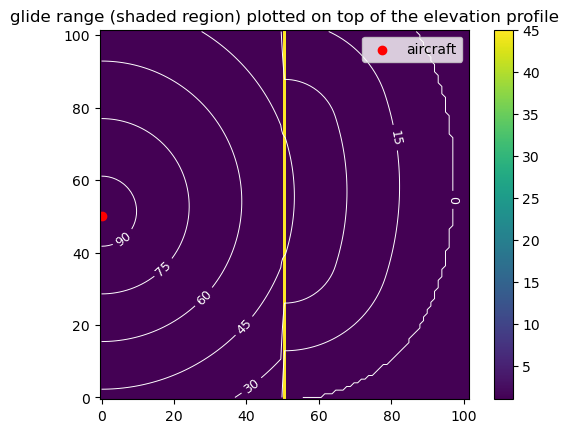

In [22]:
true_grid=np.zeros([H,W])
radius=np.sqrt((H*hy)**2+(hx*W)**2)
init_nodes,init_values,init_chars=point_source_HJB_uniform_solver(init_pos,init_altitude,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
for y in range(H):
    for x in range(W):
        true_grid[y,x]=init_values[init_nodes.index((y,x))]

blocked_down_y=0
for y in range(0,H//2):
    if(elevation[y,W//2]>true_grid[y,W//2]):
        blocked_down_y=y
blocked_down_y=blocked_down_y+1

for y in range(H//2,H):
    if(elevation[y,W//2]>true_grid[y,W//2]):
        blocked_up_y=y
        break
blocked_up_y=blocked_up_y-1
init_nodes_up,init_values_up,init_chars_up=point_source_HJB_uniform_solver((blocked_up_y,W//2),true_grid[blocked_up_y,W//2],2*radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
init_nodes_down,init_values_down,init_chars_down=point_source_HJB_uniform_solver((blocked_down_y,W//2),true_grid[blocked_down_y,W//2],2*radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
for x in range(W//2,W):
    for y in range(0,blocked_down_y):
        y_int=y+(x-W//2)/x*(init_pos[0]-y)
        if(y_int<blocked_down_y):
            true_grid[y,x]=init_values_down[init_nodes_down.index((y,x))]
for x in range(W//2,W):
    for y in range(blocked_up_y,H):
        y_int=y+(x-W//2)/x*(init_pos[0]-y)
        if(y_int>blocked_up_y):
            true_grid[y,x]=init_values_up[init_nodes_up.index((y,x))]

true_grid=np.maximum(true_grid,np.zeros_like(true_grid))
     
X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))
fig,ax=plt.subplots()

pc=ax.pcolormesh(X,Y,elevation,cmap='viridis',shading='nearest')
#pc2=ax.pcolormesh(X,Y,grid>0,cmap='binary',shading='nearest',alpha=0.1)
ax.scatter([init_pos[1]*hx],[init_pos[0]*hy],color='r',label='aircraft')
ax.legend()
fig.colorbar(pc)
CS=ax.contour(X,Y,true_grid,colors='w',label='aircraft',linewidths=0.7)
ax.clabel(CS, fontsize=9, inline=True)
ax.set_aspect('equal')
ax.set_title('glide range (shaded region) plotted on top of the elevation profile')

Text(0.5, 1.0, 'total error lost altitude')

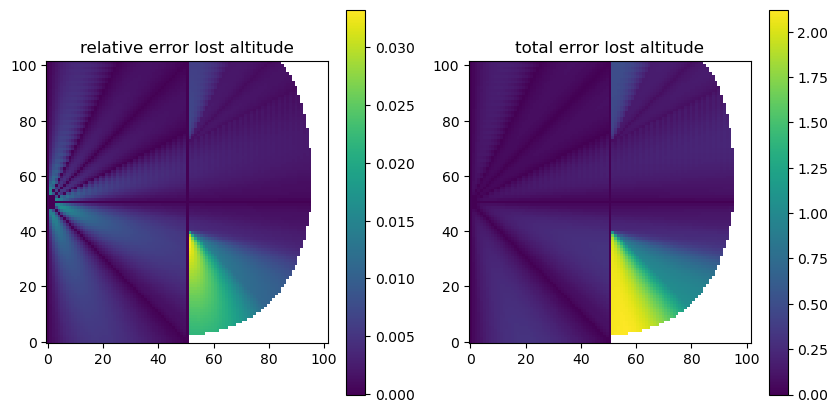

In [23]:
grid[:,W//2]=0
true_grid[:,W//2]=0
lost_altitude=init_altitude-grid
true_lost_altitude=init_altitude-true_grid
tot_error=(lost_altitude-true_lost_altitude)
rel_error=tot_error/(true_lost_altitude+1e-10)
fig,axes=plt.subplots(1,2,figsize=(10,5))
im1=axesim1=axes[0].pcolormesh(X,Y,rel_error,cmap='viridis',shading='nearest')
im2=axes[1].pcolormesh(X,Y,tot_error,cmap='viridis',shading='nearest')

fig.colorbar(im1,ax=axes[0])
fig.colorbar(im2,ax=axes[1])
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

axes[0].set_title('relative error lost altitude')
axes[1].set_title('total error lost altitude')